In [421]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#scikit-learn related imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats 

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, TensorDataset

# imports from captum library
from captum.attr import GradientShap,FeatureAblation

from grid_search import grid_search

np.random.seed(42)  #  sets the seed for generating random numbers in NumPy
torch.manual_seed(1234) # sets the seed for generating random numbers in PyTorch

In [387]:
BD_synthetic = pd.read_csv('../data/BD_synthetic.csv', index_col=False)
HC_synthetic = pd.read_csv('../data/HC_synthetic.csv', index_col=False)

In [388]:
# helper functions
def selectFeatures(df, feature_names):
    contains_columns = df.columns.str.contains(feature_names)
    subset_df = df.iloc[:, contains_columns]
    return subset_df

In [389]:
pattern = 'FLAIR|Corpus Callosum|hippocampal plus parahippocampal|Age' # select features that are correlated with BD vs. HC differences found in previous studies
HC_synthetic = selectFeatures(HC_synthetic, pattern) 

In [390]:
X = HC_synthetic.drop(columns=['Age at Visit']).values  
y = HC_synthetic['Age at Visit'].values 

In [391]:
normalized_X = X- np.min(X)/np.max(X) - np.min(X) # MinMax normalization

In [392]:
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.3, random_state=0) # create test and train sets

In [393]:
tstat, p_val = stats.ttest_ind(y_train, y_test) # ensure that the distribution of ages between the train and test sets are similar by doing a t-test
print(tstat, p_val)

-1.2978001943948343 0.19688720115262107


### Tensorize the datasets

In [394]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()




In [435]:
param_grid = {
    'batch_size': [32, 50, 64, 128],
    'learning_rate': [0.001, 0.0001, 0.00001],
    'size_hidden1': [50, 100, 150],
    'size_hidden2': [25, 50, 75],
    'size_hidden3': [5, 10, 20],
    'num_epochs': [50, 100, 150]  # This is typically fixed during a single round of experiments
}

val_data = TensorDataset(X_train[60:], y_train[60:])
train_data =  TensorDataset(X_train[:60], y_train[:60])

best_params, best_score = grid_search(model, param_grid,train_data, val_data)

stats.ttest_ind(y_train[60:], y_test[:60])

Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 5, 'num_epochs': 50} Score: 114.95833587646484
Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 5, 'num_epochs': 100} Score: 115.5235824584961
Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 5, 'num_epochs': 150} Score: 115.48816680908203
Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 10, 'num_epochs': 50} Score: 111.44397735595703
Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 10, 'num_epochs': 100} Score: 110.41278076171875
Tested Params: {'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 25, 'size_hidden3': 10, 'num_epochs': 150} Score: 111.4888687133789
Tested Params: {'batch_size':

TtestResult(statistic=array([-1.1560197], dtype=float32), pvalue=array([0.25241285]), df=array([58.]))

In [436]:
print(best_params, best_score)

{'batch_size': 32, 'learning_rate': 0.001, 'size_hidden1': 50, 'size_hidden2': 75, 'size_hidden3': 10, 'num_epochs': 50} 107.90896606445312


32

### Create a Python class to represent the Brain Age Model

In [437]:
# Define hyperparameters for the model
batch_size = 32
num_epochs = 50
learning_rate = 0.001
size_hidden1 = 50
size_hidden2 = 75
size_hidden3 = 10
size_hidden4 = 1

datasets = TensorDataset(X_train, y_train)
train_iter = DataLoader(datasets, best_params['batch_size'], shuffle=True)

# Create a class representing a brain age prediction model based on 4 layers of NNs
class BrainAgeModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # First layer: linear transformation from input size to first hidden layer size
        self.lin1 = nn.Linear(input_size, size_hidden1)
        # Activation function for the first hidden layer
        self.relu1 = nn.ReLU()
        # Second layer: linear transformation from first to second hidden layer size
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        # Activation function for the second hidden layer
        self.relu2 = nn.ReLU()
        # Third layer: linear transformation from second to third hidden layer size
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        # Activation function for the third hidden layer
        self.relu3 = nn.ReLU()
        # Output layer: linear transformation from third hidden layer size to output size
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)

    def forward(self, input):
        # Define the forward pass through the network
        x = self.lin1(input)
        x = self.relu1(x)
        x = self.lin2(x)
        x = self.relu2(x)
        x = self.lin3(x)
        x = self.relu3(x)
        x = self.lin4(x)
        return x



In [438]:
model = BrainAgeModel(9)
model.train()

BrainAgeModel(
  (lin1): Linear(in_features=9, out_features=50, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=50, out_features=75, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=75, out_features=10, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

In [439]:
criterion = nn.MSELoss(reduction='sum')

In [442]:
def train(model_inp, num_epochs = num_epochs):
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

In [447]:
criterion = nn.MSELoss(reduction='sum')

### Test model on data from healthy individuals 

In [448]:
model.eval()
y_pred = model(X_test)
err = (mean_squared_error(y_pred.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

model err:  12660.407


In [449]:
mean_absolute_error(y_pred.detach().numpy(), y_test.detach().numpy())

111.168434

In [450]:
gs = GradientShap(model)
fa = FeatureAblation(model)

gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

In [451]:
features = HC_synthetic.iloc[:, 1:].columns

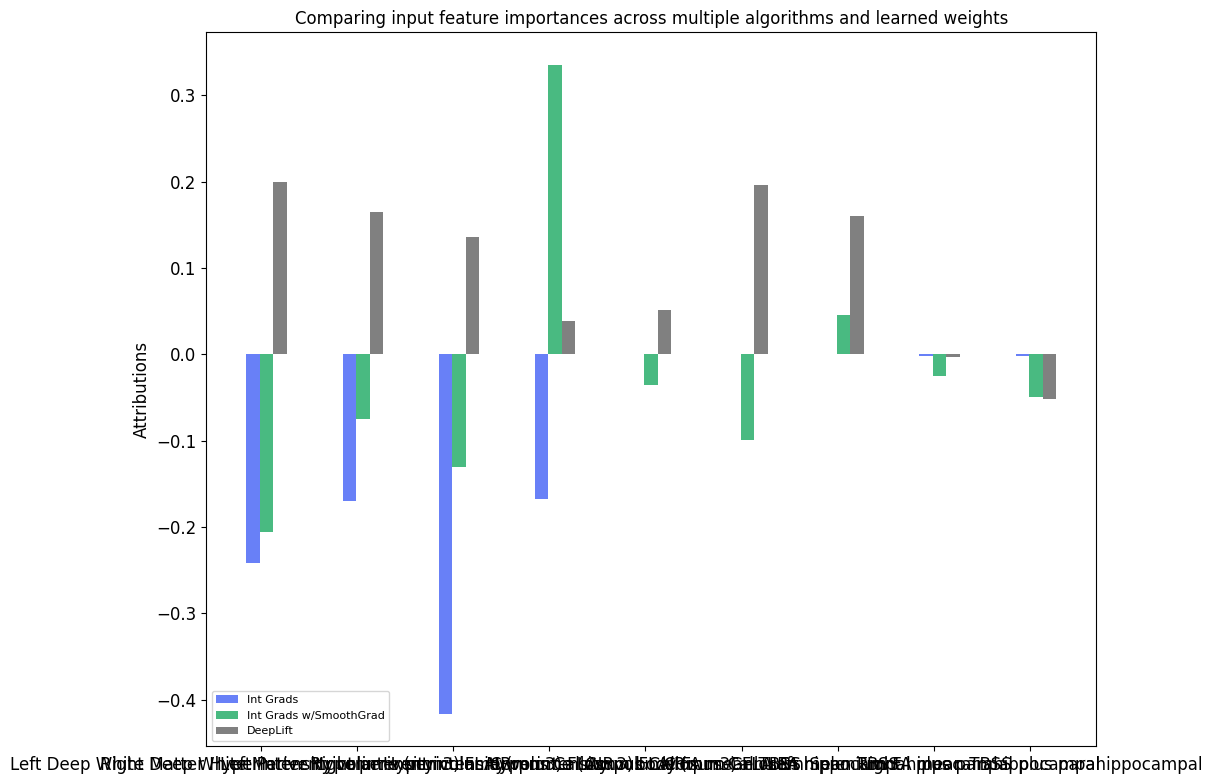

In [460]:
# prepare attributions for visualization
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: features[idx], x_axis_data))

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(10, 8))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 12
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

### Test model on data from individuals with BD

In [453]:
pattern = 'FLAIR|Corpus Callosum|hippocampal plus parahippocampal|Age'
BD_X = selectFeatures(BD_synthetic, pattern)
BD_X = BD_X.drop(columns= ['Age at Visit']).values
BD_y = BD_synthetic['Age at Visit'].values

In [454]:
normalized_BD_X = BD_X - np.min(BD_X)/(np.max(BD_X)- np.min(BD_X))

In [455]:
normalized_BD_X = torch.tensor(normalized_BD_X).float()
BD_y = torch.tensor(BD_y).view(-1, 1).float()

In [456]:
model.eval()
BD_y_pred = model(normalized_BD_X)


In [459]:
err = (mean_squared_error(BD_y_pred.detach().numpy(), BD_y.detach().numpy()))
print(err)

3111.2656
